In [ ]:
#Project 1
#Mangirish Kulkarni
#ASU Id- 1223229852
#NASA Atlantis STS-129

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [ ]:
# environment parameters-

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCELERATION = 9.81  # gravity const g = 9.81 m/s^2
BOOST_ACCELERATION = 14.715  # assuming thrust const to be 14.715 m/s^2 (Usually >g)

# # Unused parameters-
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [ ]:
# define system dynamics-
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        action[0] = y-direction thrust 
        action[1] = x-direction thrust 
        state[0] = y
        state[1] = y_dot
        state[2] = x
        state[3] = x_dot
        """
       
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        
        delta_state_gravity = t.tensor([0., GRAVITY_ACCELERATION * FRAME_TIME, 0., 0.]) #2D conversion

        # For Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state_x = BOOST_ACCELERATION * FRAME_TIME * t.tensor([0., 0., 0., 1.]) * action[1]  #2D conversion in x
        delta_state_y = BOOST_ACCELERATION * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0] #2D conversion in y     
        V = delta_state_y
        
        """"
        Rocket model- Atlantis STS-129
        Ref: http://www.spacefacts.de/mission/english/sts-129.htm   ...(Link 1)
        Ref: https://en.wikipedia.org/wiki/STS-129  ...(Link 2)

        Drag effect calculations-
        Drag force: DF = Cd * A * 0.5 * row * V^2   ...(Eqn 1; Ref:https://www.grc.nasa.gov/www/k-12/rocket/drageq.html#:~:text=The%20drag%20equation%20states%20that,times%20the%20reference%20area%20A.&text=For%20given%20air%20conditions%2C%20shape,for%20Cd%20to%20determine%20drag.)
        
        Cd = 0.5 (Drag co-efficient) ...(Link 2)
        A = pi * 16 feet ^2 (16 feet=4.8768m) = 74.71705804 m^2 ...(Link 2)
        row = 8050 kg/m^3 (steel density, Ref:https://www.toppr.com/guides/physics/fundamentals/density-of-steel-how-to-calculate-the-density-of-metal/#:~:text=That's%20why%20the%20density%20of,the%20densest%20alloy%20or%20metal.) 
        V = velocity = delta state (Link 1; Landing Vel= 365 km/hr=101.389 m/s)
        m = 93063 Kg (Link 1; Mass at landing of Atlantis STS-129)

        Inputing in eqn 1, we get,
        DF = 0.5 * 74.71705804 * 0.5 * 8050 * V**2
        DF = 150368.0793 * V**2 
        
        Now Decl due to drag-
        
        DRAG_DECELERATION (deceleration due to drag) = DF/m 
        
        """
        #Drag-
        DRAG_DECELERATION = 1.615766516 * V**2
        
        NET_ACCELERATION = BOOST_ACCELERATION - DRAG_DECELERATION # Net accln in Y direction
        
        #Now new Velocity in Y-direction-
        delta_state_y = NET_ACCELERATION * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0]

        # Update velocity-
        state = state + delta_state_y + delta_state_gravity + delta_state_x
        
        # Update state-
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [ ]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),#added new layer
            nn.Linear(dim_hidden, dim_hidden),#added new layer
            nn.Tanh(),#added new layer
            nn.Tanh(),#added a new layer
            nn.Linear(dim_hidden, dim_output),#added new hidden layer
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [ ]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        #Rocket is coming down from a height of 10 m with 0 m/s initial velocity in Y
        #Rocket is 5 m to the right of target landing side with -1 m/s initial velocity in X
        state = [20., 0., 10., -2.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

In [ ]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('_______________________________________________________________________________________________________________')
            print('\nIteration number:\t',epoch+1)
            print('loss: %.3f' % (loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        a = data[:, 0]
        b = data[:, 1]
        c = data[:, 2]
        d = data[:, 3]
        
        plt.figure()
        plt.subplot(221)
        plt.title('Distance in Y vs velocity in Y plot')
        plt.xlabel('Distance in Y')
        plt.ylabel('Velocity in Y')
        plt.plot(a, b)
        
        plt.subplot(222)
        plt.title('Distance in X vs velocity in X plot')
        plt.xlabel('Distance in X')
        plt.ylabel('Velocity in X')
        plt.plot(c, d)
        plt.tight_layout()
        plt.show()

_______________________________________________________________________________________________________________

Iteration number:	 1
loss: 117812.922


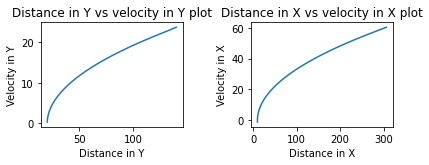

_______________________________________________________________________________________________________________

Iteration number:	 2
loss: 58451.883


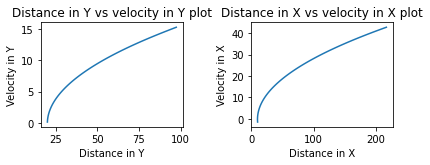

_______________________________________________________________________________________________________________

Iteration number:	 3
loss: 37866.066


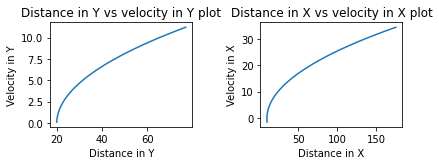

_______________________________________________________________________________________________________________

Iteration number:	 4
loss: 27253.021


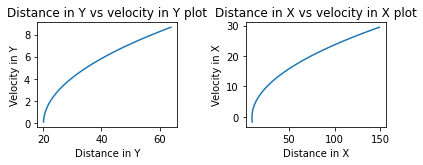

_______________________________________________________________________________________________________________

Iteration number:	 5
loss: 20314.717


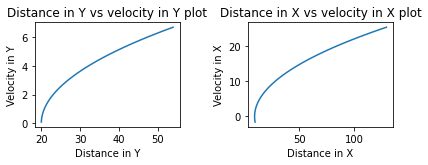

_______________________________________________________________________________________________________________

Iteration number:	 6
loss: 15145.119


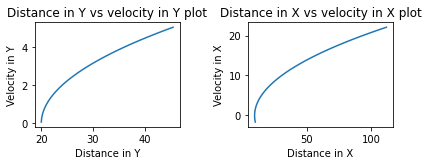

_______________________________________________________________________________________________________________

Iteration number:	 7
loss: 10218.019


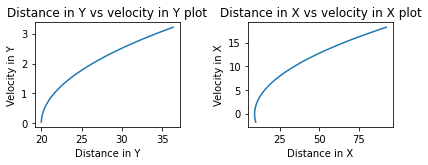

_______________________________________________________________________________________________________________

Iteration number:	 8
loss: 4964.897


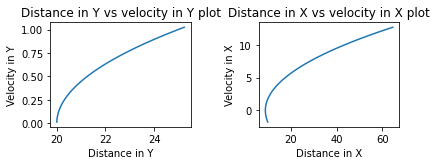

_______________________________________________________________________________________________________________

Iteration number:	 9
loss: 2605.194


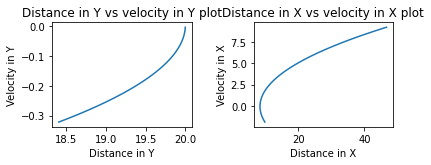

_______________________________________________________________________________________________________________

Iteration number:	 10
loss: 1522.937


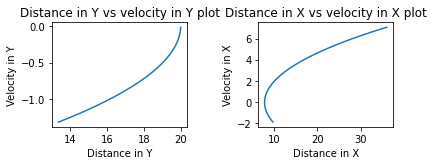

_______________________________________________________________________________________________________________

Iteration number:	 11
loss: 944.113


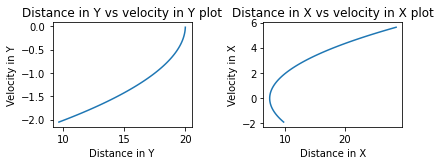

_______________________________________________________________________________________________________________

Iteration number:	 12
loss: 625.791


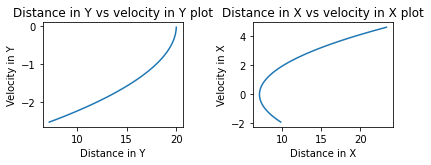

_______________________________________________________________________________________________________________

Iteration number:	 13
loss: 425.820


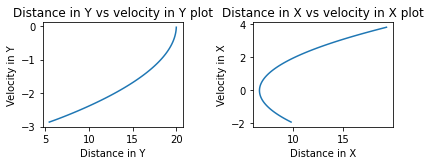

_______________________________________________________________________________________________________________

Iteration number:	 14
loss: 293.219


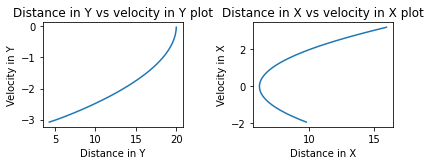

_______________________________________________________________________________________________________________

Iteration number:	 15
loss: 211.271


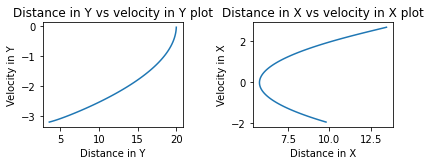

_______________________________________________________________________________________________________________

Iteration number:	 16
loss: 156.190


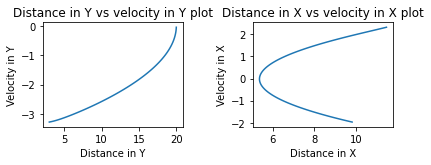

_______________________________________________________________________________________________________________

Iteration number:	 17
loss: 113.921


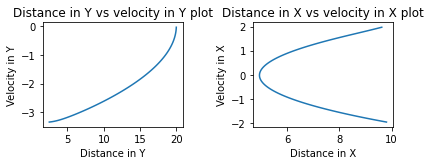

_______________________________________________________________________________________________________________

Iteration number:	 18
loss: 70.593


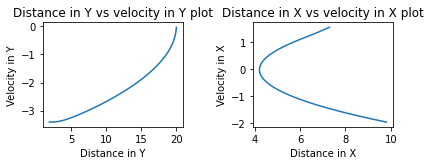

_______________________________________________________________________________________________________________

Iteration number:	 19
loss: 39.016


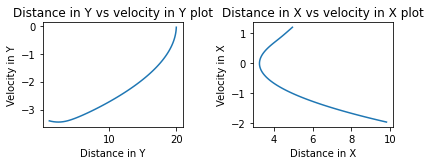

_______________________________________________________________________________________________________________

Iteration number:	 20
loss: 25.951


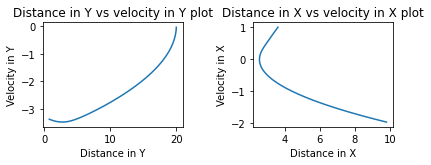

_______________________________________________________________________________________________________________

Iteration number:	 21
loss: 18.920


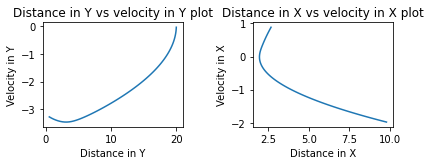

_______________________________________________________________________________________________________________

Iteration number:	 22
loss: 13.783


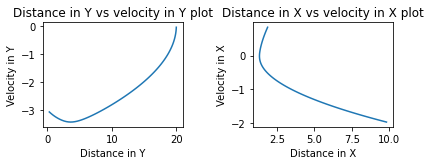

_______________________________________________________________________________________________________________

Iteration number:	 23
loss: 8.922


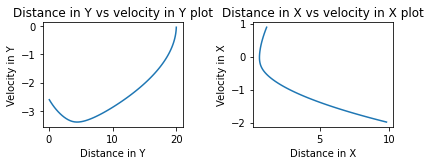

_______________________________________________________________________________________________________________

Iteration number:	 24
loss: 5.347


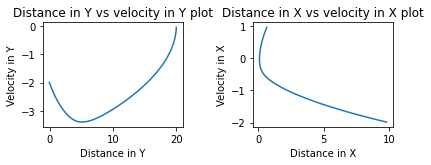

_______________________________________________________________________________________________________________

Iteration number:	 25
loss: 3.179


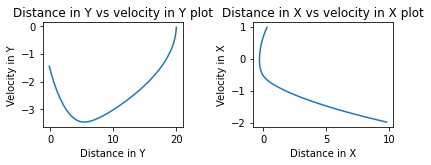

_______________________________________________________________________________________________________________

Iteration number:	 26
loss: 1.892


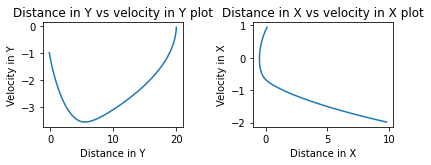

_______________________________________________________________________________________________________________

Iteration number:	 27
loss: 1.218


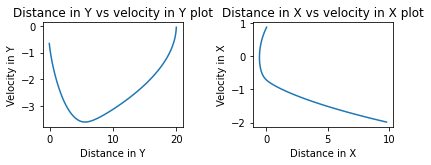

_______________________________________________________________________________________________________________

Iteration number:	 28
loss: 0.865


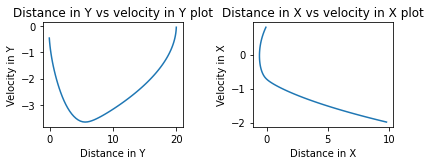

_______________________________________________________________________________________________________________

Iteration number:	 29
loss: 0.650


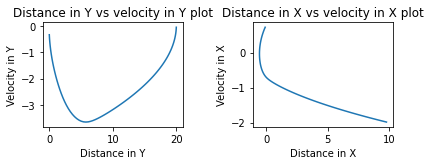

_______________________________________________________________________________________________________________

Iteration number:	 30
loss: 0.494


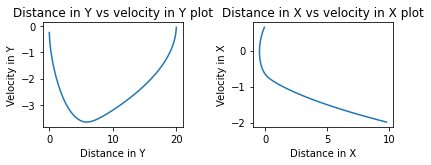

_______________________________________________________________________________________________________________

Iteration number:	 31
loss: 0.366


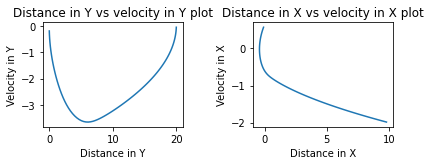

_______________________________________________________________________________________________________________

Iteration number:	 32
loss: 0.263


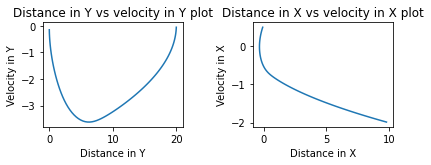

_______________________________________________________________________________________________________________

Iteration number:	 33
loss: 0.182


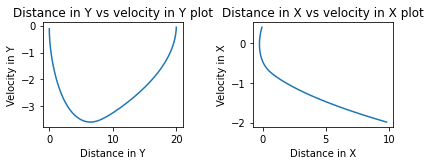

_______________________________________________________________________________________________________________

Iteration number:	 34
loss: 0.121


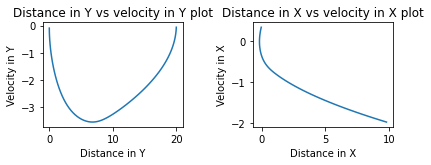

_______________________________________________________________________________________________________________

Iteration number:	 35
loss: 0.079


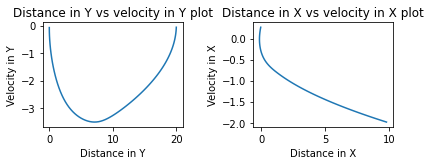

_______________________________________________________________________________________________________________

Iteration number:	 36
loss: 0.051


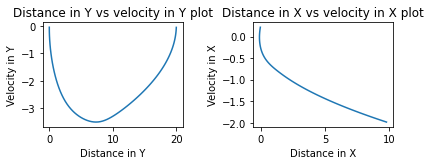

_______________________________________________________________________________________________________________

Iteration number:	 37
loss: 0.033


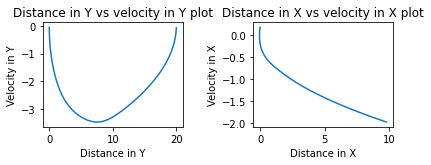

_______________________________________________________________________________________________________________

Iteration number:	 38
loss: 0.021


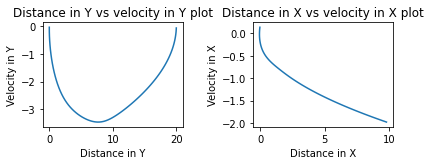

_______________________________________________________________________________________________________________

Iteration number:	 39
loss: 0.014


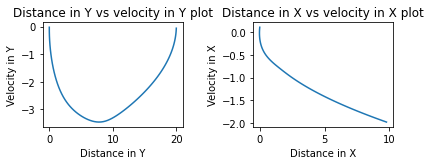

_______________________________________________________________________________________________________________

Iteration number:	 40
loss: 0.009


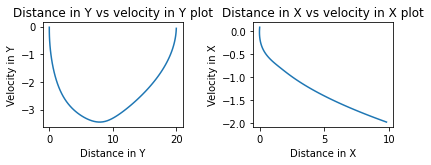

_______________________________________________________________________________________________________________

Iteration number:	 41
loss: 0.006


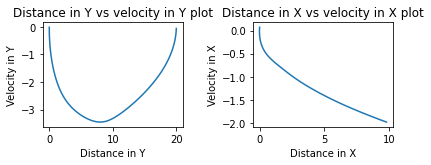

_______________________________________________________________________________________________________________

Iteration number:	 42
loss: 0.004


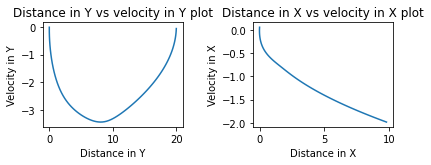

_______________________________________________________________________________________________________________

Iteration number:	 43
loss: 0.002


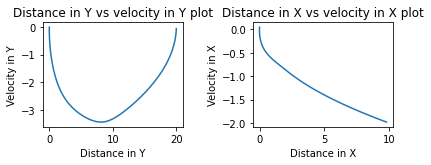

_______________________________________________________________________________________________________________

Iteration number:	 44
loss: 0.002


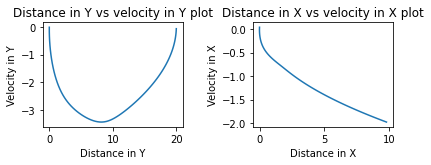

_______________________________________________________________________________________________________________

Iteration number:	 45
loss: 0.001


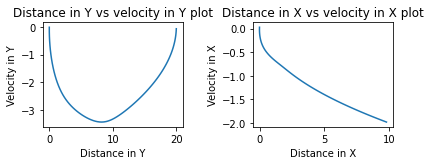

_______________________________________________________________________________________________________________

Iteration number:	 46
loss: 0.001


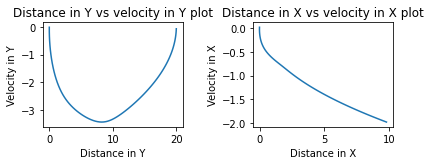

_______________________________________________________________________________________________________________

Iteration number:	 47
loss: 0.000


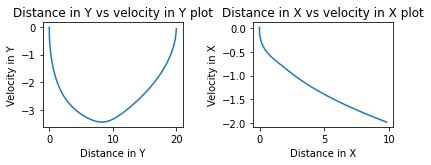

_______________________________________________________________________________________________________________

Iteration number:	 48
loss: 0.000


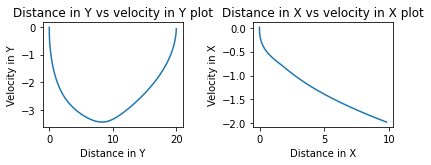

_______________________________________________________________________________________________________________

Iteration number:	 49
loss: 0.000


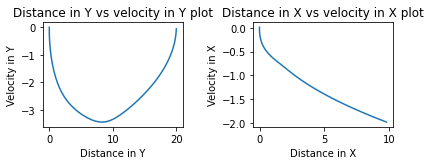

_______________________________________________________________________________________________________________

Iteration number:	 50
loss: 0.000


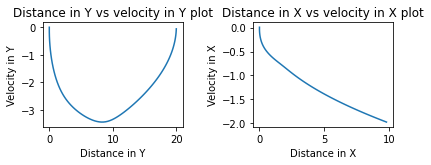

_______________________________________________________________________________________________________________

Iteration number:	 51
loss: 0.000


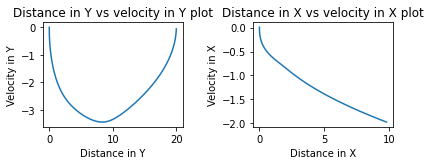

_______________________________________________________________________________________________________________

Iteration number:	 52
loss: 0.000


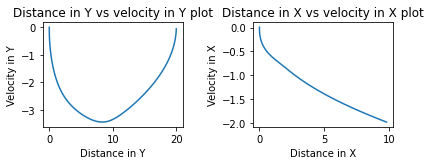

_______________________________________________________________________________________________________________

Iteration number:	 53
loss: 0.000


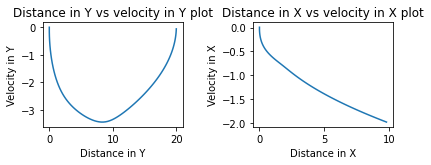

_______________________________________________________________________________________________________________

Iteration number:	 54
loss: 0.000


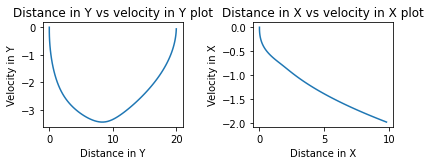

_______________________________________________________________________________________________________________

Iteration number:	 55
loss: 0.000


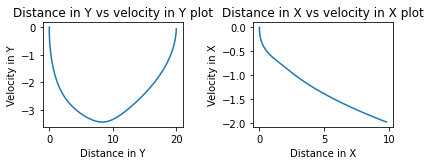

_______________________________________________________________________________________________________________

Iteration number:	 56
loss: 0.000


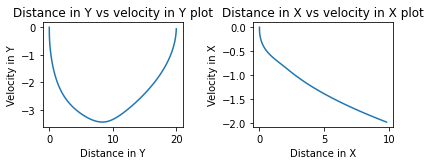

_______________________________________________________________________________________________________________

Iteration number:	 57
loss: 0.000


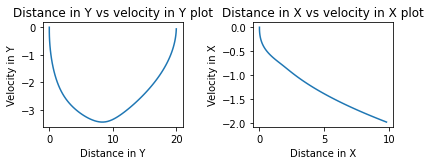

_______________________________________________________________________________________________________________

Iteration number:	 58
loss: 0.000


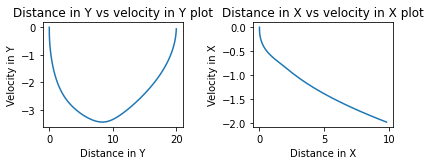

_______________________________________________________________________________________________________________

Iteration number:	 59
loss: 0.000


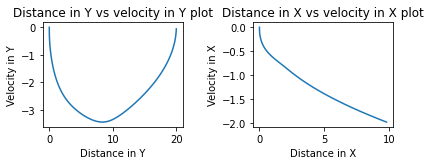

_______________________________________________________________________________________________________________

Iteration number:	 60
loss: 0.000


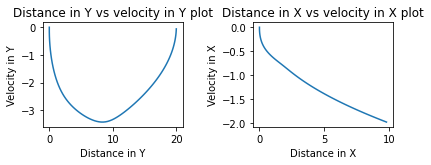

In [ ]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4  # state space dimensions (x, x_dot, y, y_dot)
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions (action_x, action_y)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(60)  # solve the optimization problem